In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

In [2]:
def load_data():
    # Load the mpg dataset from the local file 'auto-mpg.data'
    columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 
               'weight', 'acceleration', 'model_year', 'origin', 'car_name']
    
    # Load the data, handling missing values represented by '?'
    data = pd.read_fwf('./a1_code/auto-mpg.data', 
                       names=columns, na_values='?')
    
    # Drop any rows with missing values
    data = data.dropna()
    
    # Extract target values (mpg) and input variables
    t = data['mpg'].values  # Target variable
    X = data[['cylinders', 'displacement', 'horsepower', 
               'weight', 'acceleration', 'model_year', 'origin']].values  # Input variables

    # Load the permutation 'rp' from the .mat file
    rp_data = scipy.io.loadmat('./a1_code/rp.mat')
    rp = rp_data['rp'].flatten() - 1  # Flatten the array to 1D if necessary

    # Apply the permutation to randomize the rows
    X = X[rp, :]
    y = t[rp]

    return y, X

In [3]:
y, X = load_data()

X_norm = (X - X.mean(axis=0)) / X.std(axis=0)
y_norm = (y - y.mean(axis=0)) / y.std(axis=0)

In [4]:
# Split into training and testing sets
X_train, X_test = X_norm[:100], X_norm[100:]
y_train, y_test = y_norm[:100], y_norm[100:]

In [5]:
# Initialize lists to store errors
train_errors = []
test_errors = []

# Fit polynomial regression models for degrees 1 to 10
for degree in range(1, 11):
    # Transform the single feature with polynomial terms up to the specified degree
    X_train_poly = np.ones((X_train.shape[0], 1))
    X_test_poly = np.ones((X_test.shape[0], 1))
    for deg in range(1, degree+1):
        X_train_poly = np.hstack([X_train_poly, X_train**deg])
        X_test_poly = np.hstack([X_test_poly, X_test**deg])

    coef = np.linalg.lstsq(X_train_poly, y_train, rcond=None)[0]
    y_train_pred = X_train_poly @ coef
    y_test_pred = X_test_poly @ coef 

    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)
    
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)

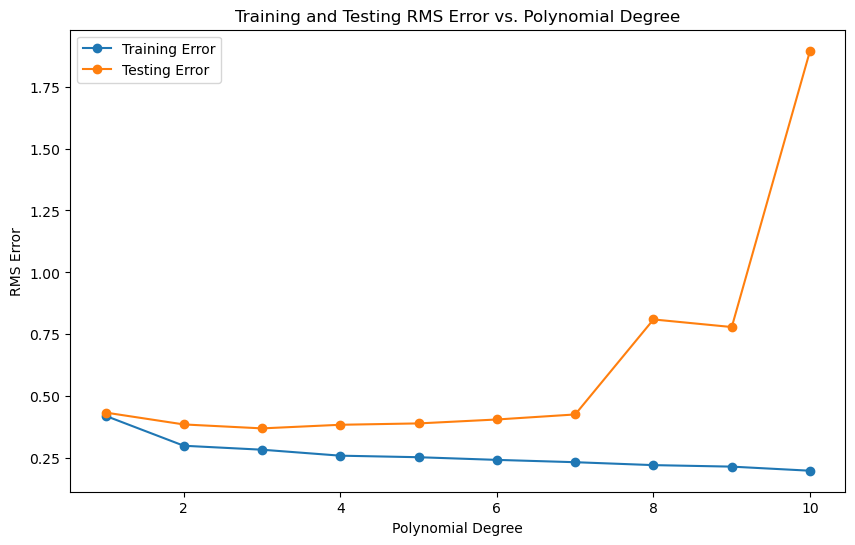

In [6]:
# Plot training and testing error versus polynomial degree
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), train_errors, label='Training Error', marker='o')
plt.plot(range(1, 11), test_errors, label='Testing Error', marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('RMS Error')
plt.title('Training and Testing RMS Error vs. Polynomial Degree')
plt.legend()
plt.show()

# part 2

In [7]:
# Assuming the data has already been loaded and normalized as in Part 1
# Selecting only the third feature (index 2 since Python uses zero-based indexing)
X_single_feature = X_norm[:, 2].reshape(-1, 1)  # Using only the "horsepower" feature here
X_train_single, X_test_single = X_single_feature[:100], X_single_feature[100:]
y_train, y_test = y_norm[:100], y_norm[100:]

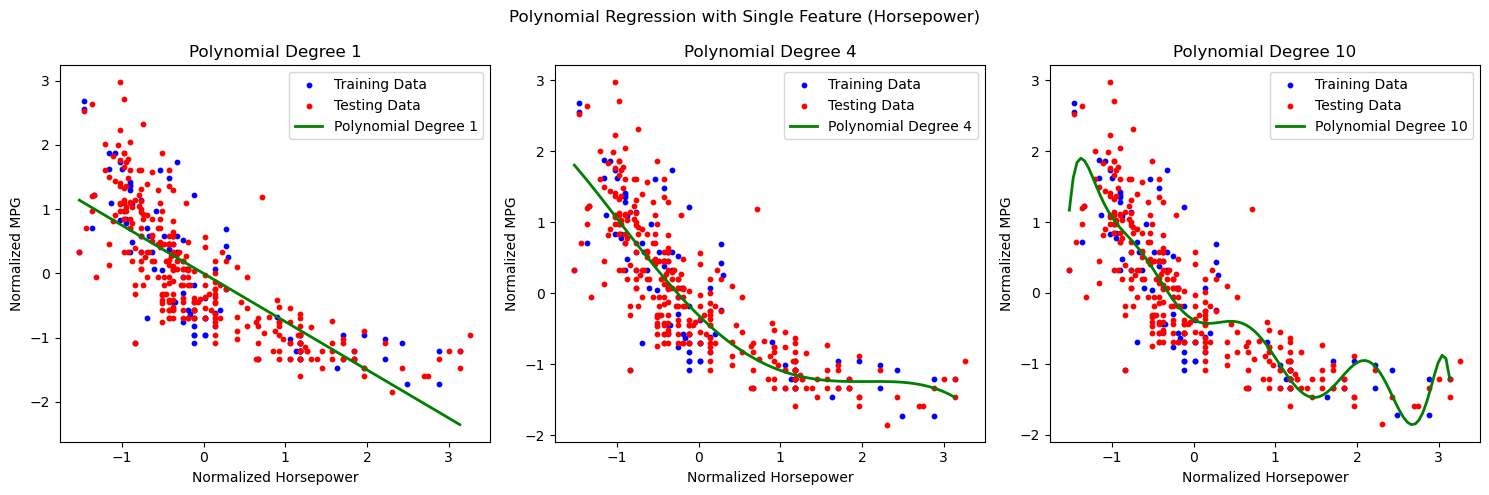

In [8]:
# List of degrees for which we will visualize the polynomial regression fit
degrees_to_plot = [1, 4, 10]  # Low, medium, and high degree polynomials

plt.figure(figsize=(15, 5))

for deg, degree in enumerate(degrees_to_plot):
    # Transform the single feature with polynomial terms up to the specified degree
    X_train_poly = np.ones((X_train_single.shape[0], 1))
    X_test_poly = np.ones((X_test_single.shape[0], 1))
    for deg_single in range(1, degree+1):
        X_train_poly = np.hstack([X_train_poly, X_train_single**deg_single])
        X_test_poly = np.hstack([X_test_poly, X_test_single**deg_single])
        
    coef = np.linalg.lstsq(X_train_poly, y_train, rcond=None)[0]
    y_train_pred = X_train_poly @ coef
    y_test_pred = X_test_poly @ coef 

    # Plot the data points and the learned polynomial curve
    plt.subplot(1, len(degrees_to_plot), deg + 1)
    plt.scatter(X_train_single, y_train, color='blue', label='Training Data', s=10)
    plt.scatter(X_test_single, y_test, color='red', label='Testing Data', s=10)
    
    # For smoother polynomial curve, use a dense set of points within the range of the training data
    X_range = np.linspace(X_train_single.min(), X_train_single.max(), 100).reshape(-1, 1)
    X_range_poly = np.ones((X_range.shape[0], 1))
    for deg_range in range(1, degree+1):
        X_range_poly = np.hstack([X_range_poly, X_range**deg_range])
    y_range_pred = X_range_poly @ coef
    
    # Plot the polynomial curve
    plt.plot(X_range, y_range_pred, color='green', label=f'Polynomial Degree {degree}', linewidth=2)

    # Add titles and labels
    plt.title(f'Polynomial Degree {degree}')
    plt.xlabel('Normalized Horsepower')
    plt.ylabel('Normalized MPG')
    plt.legend()

plt.suptitle('Polynomial Regression with Single Feature (Horsepower)')
plt.tight_layout()
plt.show()

# Part 3

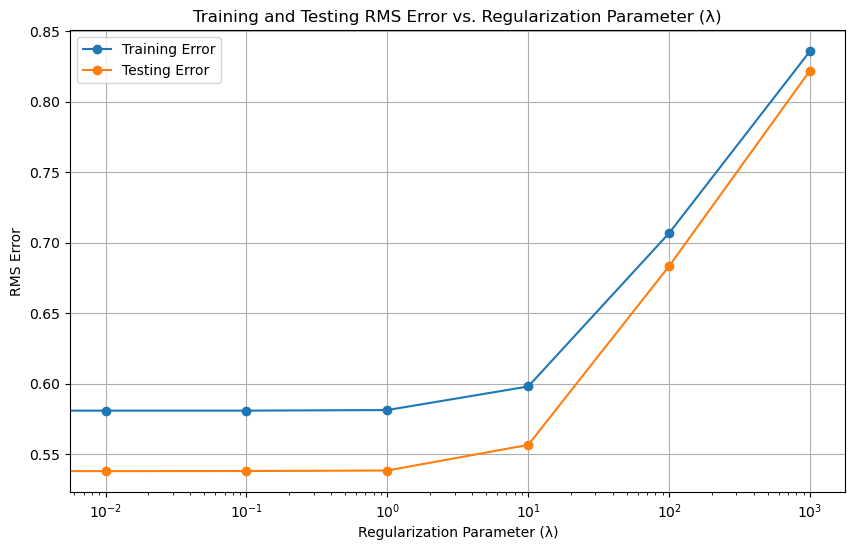

In [9]:
# Selecting only the third feature (normalized horsepower)
X_single_feature = X_norm[:, 2].reshape(-1, 1)
X_train_single, X_test_single = X_single_feature[:100], X_single_feature[100:]
y_train, y_test = y_norm[:100], y_norm[100:]

# Set polynomial degree and regularization values
degree = 8
lambdas = [0, 0.01, 0.1, 1, 10, 100, 1000]  # Regularization parameters

# Lists to store training and testing errors for each lambda
train_errors = []
test_errors = []

# Function to fit polynomial regression with L2 regularization
def fit_polynomial_l2(X, y, degree, lambda_value):
    # Generate polynomial features up to the specified degree
    X_poly = np.ones((X.shape[0], 1))
    for d in range(1, degree + 1):
        X_poly = np.hstack([X_poly, X ** d])

    # Apply L2 regularization in the normal equation: (X^T X + λI)θ = X^T y
    I = np.eye(X_poly.shape[1])  # Identity matrix for regularization
    I[0, 0] = 0  # Do not regularize the bias term

    theta = np.linalg.solve(X_poly.T @ X_poly + lambda_value * I, X_poly.T @ y)
    
    return theta, X_poly

# Loop over each regularization value
for lambda_value in lambdas:
    # Fit model on training data
    theta, X_train_poly = fit_polynomial_l2(X_train_single, y_train, degree, lambda_value)

    # Predict on training and testing sets
    y_train_pred = X_train_poly @ theta
    X_test_poly = np.ones((X_test_single.shape[0], 1))
    for d in range(1, degree + 1):
        X_test_poly = np.hstack([X_test_poly, X_test_single ** d])
    y_test_pred = X_test_poly @ theta

    # Calculate RMSE for both training and testing sets
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)
    
    # Append errors to lists
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)

# Plotting training and testing errors vs. regularizer values on a semilog scale
plt.figure(figsize=(10, 6))
plt.semilogx(lambdas, train_errors, label='Training Error', marker='o')
plt.semilogx(lambdas, test_errors, label='Testing Error', marker='o')
plt.xlabel('Regularization Parameter (λ)')
plt.ylabel('RMS Error')
plt.title('Training and Testing RMS Error vs. Regularization Parameter (λ)')
plt.legend()
plt.grid(True)
plt.show()


# part 4-a

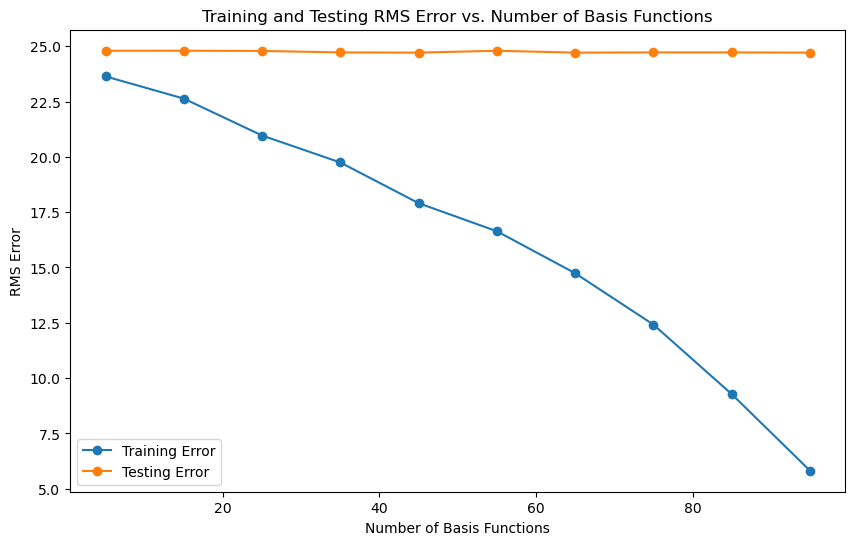

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def dist2(x, c):
    """
    Calculates the squared Euclidean distance between two sets of points.
    This function mimics the functionality of the MATLAB dist2.m function.
    
    Parameters:
    x (ndarray): Array of shape (M, N) representing M points in N dimensions.
    c (ndarray): Array of shape (L, N) representing L centers in N dimensions.
    
    Returns:
    ndarray: Matrix of shape (M, L) where the (i, j)-th entry is the
             squared distance between x[i] and c[j].
    """
    ndata, dimx = x.shape
    ncentres, dimc = c.shape
    
    if dimx != dimc:
        raise ValueError("Data dimension does not match dimension of centers.")
    
    # Calculate squared distances
    n2 = (np.ones((ncentres, 1)) * np.sum(x**2, axis=1)).T \
         + np.ones((ndata, 1)) * np.sum(c**2, axis=1) \
         - 2 * (x @ c.T)
    
    # Ensure there are no negative distances due to rounding errors
    n2[n2 < 0] = 0
    
    return n2

def gaussian_basis(X, centers, s):
    """Generate a Gaussian basis matrix for input X with given centers and spread s."""
    D = dist2(X, centers)
    return np.exp(-D / (2 * s**2))

def root_mean_squared_error(y_true, y_pred):
    """Calculate the Root Mean Squared Error (RMSE)."""
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Load and preprocess data
# Assuming X and y are already loaded and normalized from previous parts of your question
# Select the first 100 samples for training and the rest for testing
X_train, X_test = X[:100], X[100:]
y_train, y_test = y[:100], y[100:]

# Gaussian basis parameters
s = 2  # Gaussian spread parameter
basis_sizes = range(5, 100, 10)  # Number of basis functions to try

# Part 1: Gaussian basis function regression with varying numbers of basis functions (no regularization)
train_errors = []
test_errors = []

for M in basis_sizes:
    # Randomly select M training points as the centers for the Gaussian basis functions
    random_indices = np.random.permutation(X_train.shape[0])[:M]
    centers = X_train[random_indices]

    # Compute Gaussian basis matrices for training and testing data
    Phi_train = gaussian_basis(X_train, centers, s)
    Phi_test = gaussian_basis(X_test, centers, s)

    # Fit linear regression model with no regularization
    theta = np.linalg.pinv(Phi_train.T @ Phi_train) @ Phi_train.T @ y_train

    # Make predictions
    y_train_pred = Phi_train @ theta
    y_test_pred = Phi_test @ theta

    # Calculate RMSE for both training and testing data
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)

    train_errors.append(train_rmse)
    test_errors.append(test_rmse)

# Plot training and testing errors for varying number of basis functions
plt.figure(figsize=(10, 6))
plt.plot(basis_sizes, train_errors, label='Training Error', marker='o')
plt.plot(basis_sizes, test_errors, label='Testing Error', marker='o')
plt.xlabel('Number of Basis Functions')
plt.ylabel('RMS Error')
plt.title('Training and Testing RMS Error vs. Number of Basis Functions')
plt.legend()
plt.show()

# part 4-b

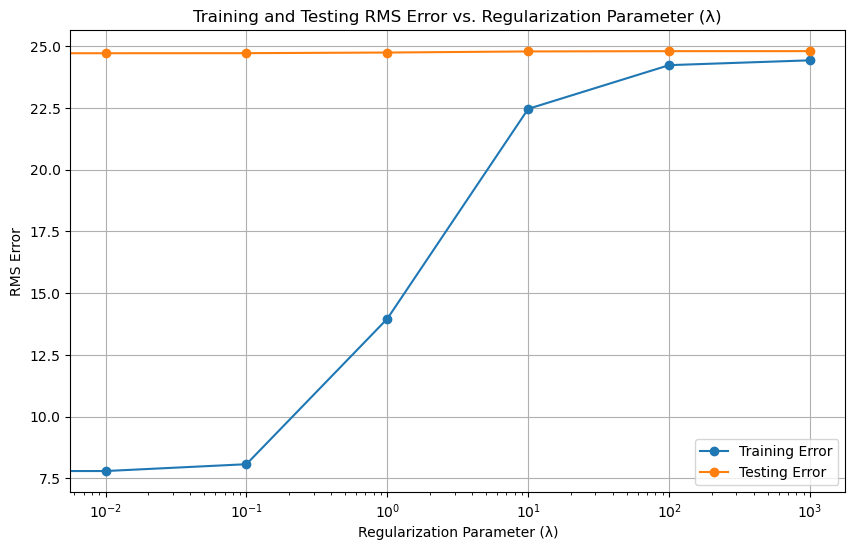

In [11]:
# Part 2: L2-regularized regression with fixed number of basis functions and varying regularization
M = 90  # Fixed number of basis functions
random_indices = np.random.permutation(X_train.shape[0])[:M]
centers = X_train[random_indices]

# Compute Gaussian basis matrices for training and testing data
Phi_train = gaussian_basis(X_train, centers, s)
Phi_test = gaussian_basis(X_test, centers, s)

# Regularization parameters to try
lambdas = [0, 0.01, 0.1, 1, 10, 100, 1000]
train_errors = []
test_errors = []

for lambda_value in lambdas:
    # Regularized solution: (Phi^T * Phi + λI)θ = Phi^T * y
    I = np.eye(Phi_train.shape[1])
    theta = np.linalg.solve(Phi_train.T @ Phi_train + lambda_value * I, Phi_train.T @ y_train)

    # Make predictions
    y_train_pred = Phi_train @ theta
    y_test_pred = Phi_test @ theta

    # Calculate RMSE for both training and testing data
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)

    train_errors.append(train_rmse)
    test_errors.append(test_rmse)

# Plot training and testing errors for varying regularization values
plt.figure(figsize=(10, 6))
plt.semilogx(lambdas, train_errors, label='Training Error', marker='o')
plt.semilogx(lambdas, test_errors, label='Testing Error', marker='o')
plt.xlabel('Regularization Parameter (λ)')
plt.ylabel('RMS Error')
plt.title('Training and Testing RMS Error vs. Regularization Parameter (λ)')
plt.legend()
plt.grid(True)
plt.show()